# 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Library load
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings('ignore', category = UserWarning, module = 'bs4')

# 모델 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Attention layer
from tensorflow.keras.layers import AdditiveAttention

# 추출 요약
import requests
from summa.summarizer import summarize

In [3]:
# 모델 파라미터
embedding_dim = 128
hidden_size = 256
common_batch_size = 256
common_epochs = 2

In [4]:
#import urllib.request
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
#data = pd.read_csv('~/aiffel/news_summarization/news_summary_more.csv', encoding='iso-8859-1') # Lookup error
data = pd.read_csv('~/aiffel/news_summarization/news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
672,Would've finished those arrested for planning ...,Praising the Maharashtra Anti-Terrorism Squad ...
59726,Will end protests if survey reveals Patidars a...,Demanding a caste survey be conducted across G...
65098,Maha's Chhatrapati Shivaji Terminus to be reva...,The State Bank of India Foundation on Tuesday ...
39439,Pregnant tribal woman carried to hospital over...,A pregnant tribal woman in Kerala's Palakkad w...
93451,3 RAW agents arrested in Pakistan-occupied Kas...,"As per Pakistani media, three suspected Resear..."
54063,Shraddha to star in Shahid's 'Batti Gul Meter ...,"As per reports, actress Shraddha Kapoor will s..."
93715,Scientists confirm galaxies are connected by d...,Canada-based researchers have captured the fir...
70183,Give more respect to other languages: Prez on ...,Addressing a function on the occasion of Hindi...
80473,Turkey bars German MPs from inspecting NATO ai...,Turkey has refused German lawmakers permission...
47048,Release date of 'Happy Phirr Bhag Jayegi' anno...,Actress Diana Penty took to Twitter to share t...


In [6]:
data.rename(columns = {'headlines' : 'Summary'}, inplace = True)
data.rename(columns = {'text' : 'Text'}, inplace = True)
text_for_extraction = data['Text']

In [7]:
print(print("Summary 전처리 전 깨진단어 존재 확인: ", data.iloc[57].loc['Summary']))

Summary 전처리 전 깨진단어 존재 확인:  McGregor fined Ã¢ÂÂ¹35 lakh, Khabib Ã¢ÂÂ¹3.5 crore for brawl; both banned
None


### 중간 회고
- 데이터를 엑셀에서 열어본 결과 깨진 단어들이 있어 별도 표기 하였다.
- 전처리를 고민하였는데, 제외해도 큰 문제가 없어 제외하기로 하였다.
- 깨진 단어는 인코딩 방식(iso-8859-1, utf-8, 없음)에 따라 조금씩 다르게 보였다.
- 깨진 단어들은 preprocess_sentence 함수에 소거 처리를 추가하였다.

# 2. 데이터 전처리하기 (추상적 요약)
- 전처리를 추가 사용하여 텍스트를 정규화 또는 정제. 
- 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민.

## (1) 중복문이나 결측 셀 제거

In [8]:
# 중복문 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수:', data['Text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수:', data['Summary'].nunique())

# 중복문 삭제.
data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수:', (len(data)))

print(data.isnull().sum())

# null 제거
data.dropna(axis = 0, inplace = True)
print('전체 샘플수:', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수: 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수: 98280
전체 샘플수: 98360
Summary    0
Text       0
dtype: int64
전체 샘플수: 98360


## (2) 텍스트 정규화와 불용어 제거

In [9]:
# 축약어 의미 통일: it'll = it will
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
print('불용어 개수:',len(stopwords.words('english')))

정규화 사전의 수:  120
불용어 개수: 179


In [10]:
# 정제 함수 정의.
def preprocess_sentence(sentence, remove_stopwords = True):
    
    # 텍스트 소문자화
    sentence = sentence.lower() 
    
    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, 'lxml').text 
    
    # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    
    # 쌍따옴표 " 제거
    sentence = re.sub('"', '', sentence)
    
    # 깨진 단어 â 제거
    sentence = re.sub('â', '', sentence)    
    
    # 깨진 단어 Ã¢ÂÂ 제거
    sentence = re.sub('Ã¢ÂÂ', '', sentence)  
    
    # 깨진 단어 â\x82¹제거
    sentence = re.sub('â\x82¹', '', sentence) 
    
    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b", "", sentence)
    
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거(text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
        
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) >1)
    return tokens

print('asdf')

asdf


In [11]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
    
# 전처리 후 출력
print('Text 전처리 후 결과:', clean_text[:5])

Text 전처리 후 결과: ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure

In [12]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))
    
print("Summary 전처리 후 결과: ", clean_summary[:5])
print("Summary 전처리 후 깨진단어 소거 확인: ", clean_summary[57])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']
Summary 전처리 후 깨진단어 소거 확인:  mcgregor fined lakh khabib crore for brawl both banned


In [13]:
# 정제된 단어를 입력.
data['Text'] = clean_text
data['Summary'] = clean_summary

# 정제 후 빈 값을 null 값으로 변환.
data.replace('', np.nan, inplace = True)

# 정제 후 결측값 재확인
print(data.isnull().sum())
data.dropna(axis=0, inplace = True)
print('전체 샘플수:', (len(data)))

Summary    0
Text       0
dtype: int64
전체 샘플수: 98360


## (3) 문장 길이 정제

텍스트의 최소 길이: 1
텍스트의 최대 길이: 60
텍스트의 평균 길이: 35.09968483123221
요약의 최소 길이: 1
요약의 최대 길이: 16
요약의 평균 길이: 9.299532330215534


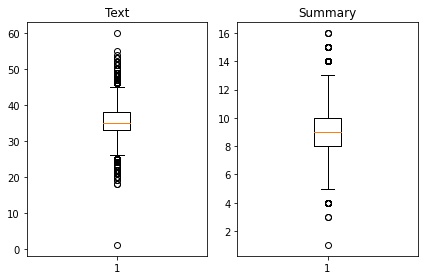

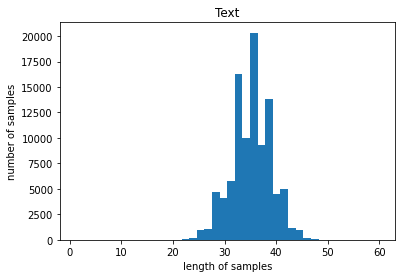

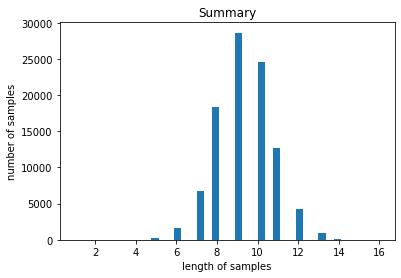

In [14]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이: {}'.format(np.min(text_len)))
print('텍스트의 최대 길이: {}'.format(np.max(text_len)))
print('텍스트의 평균 길이: {}'.format(np.mean(text_len)))
print('요약의 최소 길이: {}'.format(np.min(summary_len)))
print('요약의 최대 길이: {}'.format(np.max(summary_len)))
print('요약의 평균 길이: {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [16]:
# text 최대 길이와 summary의 적절한 최대,최소 길이. 요약문이 너무 짧으면 알아보기 힘들어 하한선을 추가하였다.

text_max_len = 50
summary_max_len = 15
summary_min_len = 7
print('asdf')

# 최대 길이 뿐 아니라 최소 길이 비율도 확인.
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

def above_threshold_len(min_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) >= min_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이상인 샘플의 비율: %s'%(min_len, (cnt/len(nested_list))))
   
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])
above_threshold_len(summary_min_len, data['Summary'])

# 정해진 길이를 벗어나면 제외하기
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) >= summary_min_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수:', (len(data)))

asdf
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653
전체 샘플 중 길이가 7 이상인 샘플의 비율: 0.9803375355835705
전체 샘플 수: 96409


## (4) 특수 토큰 추가

In [17]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x: x+' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [18]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 샘플 순서 다시 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

## (5) 훈련, 테스트 데이터 나누기

In [19]:
# 테스트 비율 정하기
percent_test = 0.2
n_of_val = int(len(encoder_input)*percent_test)  
print('테스트 데이터의 수:', n_of_val)

# 데이터 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수: 19281
훈련 데이터의 개수 : 77128
훈련 레이블의 개수 : 77128
테스트 데이터의 개수 : 19281
테스트 레이블의 개수 : 19281


## (6) 텍스트 -> 정수 인코딩

In [20]:
# 등장 빈도수가 임계치 횟수 미만인 단어들이 소스 데이터에서 얼만큼의 비중을 차지하는가?
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

threshold = 10   # 작업시간을 절약하기 위해 희귀단어의 기준 완화
total_cnt = len(src_tokenizer.word_index)   # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0   # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold 보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq = rare_freq = value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt-rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68663
등장 빈도가 9번 이하인 희귀 단어의 수: 50515
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18148
단어 집합에서 희귀 단어의 비율: 73.56946244702387
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.694397925817228e-05


In [21]:
# 단어 집합의 크기를 희귀단어 이외의 수로 제한.
src_vocab = (total_cnt-rare_cnt)
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1802, 511, 1833, 2434, 1207, 1027, 11697, 209, 366, 420, 9347, 2268, 16498, 1639, 2550, 894, 1972, 238, 82, 197, 2512, 9174, 101, 209, 420, 3554, 10366, 2248, 4053, 2447, 460, 567, 999, 11697, 4005], [3173, 298, 2206, 338, 169, 2331, 152, 3596, 659, 3816, 56, 12374, 8153, 1254, 2, 220, 298, 282, 173, 1977, 5973, 389, 3596, 476, 282, 3596, 5207, 41, 2, 104], [3, 12, 51, 2448, 6233, 4112, 1525, 11098, 1014, 1525, 96, 902, 52, 467, 8024, 340, 982, 3, 12, 583, 221, 345, 8291, 3140, 326, 67, 286, 6162, 3978, 1193, 3979, 3140]]


In [25]:
# Summary data에 대해 동일한 작업 수행. 전체 단어 집합과 각 단어에 대한 빈도수 계산.
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

# 등장 빈도수가 임계치 횟수 미만인 단어들이 타겟 데이터에서 얼만큼의 비중을 차지하는가?
threshold = 10
total_cnt = len(tar_tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold 보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
    
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29873
등장 빈도가 9번 이하인 희귀 단어의 수: 22300
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7573
단어 집합에서 희귀 단어의 비율: 74.6493489103873
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.179889257364085


In [26]:


# 사용 어휘 수는 희귀단어들만 제외하고 약 10000개 가량이다.
tar_vocab = (total_cnt - rare_cnt)
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# text to integer
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인.
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 91, 1268, 1818, 3441, 16, 86, 754], [1, 847, 2819, 524, 15, 64, 8, 2688], [1, 2938, 1106, 197, 15, 250, 66], [1, 60, 26, 97, 1478, 4, 84, 3856, 360, 43, 1236], [1, 3857, 2997, 432, 1819, 84, 58, 1186, 5169]]
target
decoder  [[91, 1268, 1818, 3441, 16, 86, 754, 2], [847, 2819, 524, 15, 64, 8, 2688, 2], [2938, 1106, 197, 15, 250, 66, 2], [60, 26, 97, 1478, 4, 84, 3856, 360, 43, 1236, 2], [3857, 2997, 432, 1819, 84, 58, 1186, 5169, 2]]


In [27]:
# 훈련 데이터와 테스트 데이터에 대해 요약문의 길이가 1인경우, 인덱스를 drop_train과 drop_test에 저장.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) ==1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77128
훈련 레이블의 개수 : 77128
테스트 데이터의 개수 : 19281
테스트 레이블의 개수 : 19281


In [28]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding = 'post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = text_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = text_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = text_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = text_max_len, padding = 'post')

# 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 어텐션 메커니즘을 사용한 seq2seq 설계.

## (1) 모델 설계하기

In [29]:
# 인코더 설계 시작

# 인코더
encoder_inputs = Input(shape = (text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences = True, return_state = True,
                     dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences = True, return_state = True,
                     dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences = True, return_state = True,
                     dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [30]:
# decoder design
decoder_inputs = Input(shape = (None,))

# 디코더의 임베딩 레이어
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True,
                   dropout = 0.4, recurrent_dropout = 0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# model define
without_attention_model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
without_attention_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      2322944     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [31]:
# 인코더의 hidden state 들과 디코더의 hidden state 들을 어텐션 함수의 입력으로 사용하고, 
# 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태.

# attention layer
attn_layer = AdditiveAttention(name = 'attention_layer')

#  인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# Attention result와 디코더의 hidden state 연결
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# model definition
attention_model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
attention_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      2322944     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## (2) 훈련하기

In [33]:
# Attention 미적용 모델
without_attention_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1)
history = without_attention_model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = common_batch_size, callbacks = [es], epochs = 1)


302/302 [==============================] - 277s 892ms/step - loss: 1.3008 - val_loss: 1.2487


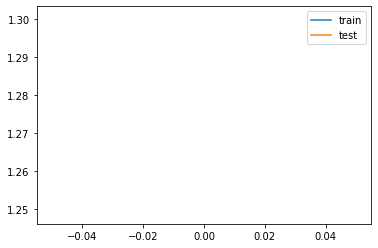

In [34]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [ ]:
# Attention 적용 모델
attention_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1)
history = attention_model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = common_batch_size, callbacks = [es], epochs = 1)


 57/302 [====>.........................] - ETA: 3:51 - loss: 1.6699

In [ ]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

## (3) 인퍼런스 모델 구현

In [ ]:
# 데이터 복원용 사전 준비

# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word 

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index

# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word

In [ ]:
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, 
                      outputs = [encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size,))
decoder_state_input_c = Input(shape = (hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

decoder_outputs2, state_h2, state_c2 = \
decoder_lstm(dec_emb2, initial_state= [decoder_state_input_h, decoder_state_input_c])

In [ ]:
# Attentional mechanism application layer

# attention function
decoder_hidden_state_input = Input(shape = (text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis = -1, name= 'concat')([decoder_outputs2, attn_out_inf])

# decoder output layer
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# final decoder model
decoder_model = Model([decoder_inputs] + \
                      [decoder_hidden_state_input, decoder_state_input_h,
                      decoder_state_input_c], [decoder_outputs2]+\
                     [state_h2, state_c2])

In [ ]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        
        output_tokens, h, c = \
        decoder_model.predict([target_seq]+[e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token != 'eostoken'):
            decoded_sentence += ' '+ sampled_token
            
        # <eos>에 도달하거나 최대길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >=\
                                              (summary_max_len-1)):    
            stop_condition = True
        
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
        
    return decoded_sentence

# 4~5. 실제 결과와 요약문 비교하기 (추상적 요약, 추출적 요약)

## (1) 추상적 출력함수 설계 및 추출적 요약 적용

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i !=0):
            temp = temp + src_index_to_word[i]+ ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if ((i != 0 and i != tar_word_to_index['sostoken']) and \
            i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp



In [ ]:
# 추출 요약. 인스턴스 형식에 맞게 작업 방식을 for 문으로 변경.
ext_summary = []
for i in range(len(text_for_extraction)):
    ext_summary.append(summarize(text_for_extraction[i], words = 15, split = True)) # 비율로 하면 생략되는 행들이 많아 단어 수로 기준 변경.

## (2) 최종 결과 확인: 원문, 실제 요약(답), 추상 요약, 추출 요약.

In [ ]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교.
for i in range(50, 100):
    print(f'<{i+1}번째 문장 요약>')
    print('원문:', seq2text(encoder_input_test[i]))
    print('실제 요약:', seq2summary(decoder_input_test[i]))
    print('추상 요약:', decode_sequence(encoder_input_test[i].
                                    reshape(1, text_max_len)))
    print('추출 요약:', ext_summary[i])
    print('\n')

# 최종 회고
- 핵심작업은 깨진단어 제거, 문장 길이 조정, 단어장 크기 재조정이었다.
- 실제 요약 문장의 길이가 짧으면 추상/추출 요약문의 어색함도 증가하였다. 분포도를 파악하고 어느 정도 분포가 많은 8~15자 사이로 정하니 품질이 많이 향상됨을 확인할 수 있었다.
- 단어장의 크기가 늘어나니 작업시간이 대충 늘어났다. 제출 시간이 임박하여 epoch 수를 줄일 수 밖에 없었던 점이 아쉽다. 시도 횟수를 늘려 추가로 돌리고 자야겠다.
- 추상 요약 알고리즘을 적용할 경우 Loss값이 미적용 모델에 비해 약 0.1정도 더 줄어드는 것을 확인하였다. 결과는 확인하였으나 알고리즘의 이해가 많이 부족하다. 논문 원문 공부가 좀 더 필요하다.